#### Imports


In [81]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

#### Functions

In [5]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    feature_cols = []
    for label in data.columns:
        if label[0] == "X" or label[0] == "Y":
            feature_cols.append(label)
        elif label[0] == "R":
            break
    

    label_cols = ["ResultPositionX", "ResultPositionY"]
    x = data[feature_cols]
    y = data[label_cols]
    return x, y

In [221]:
def adjust_x_y(x, y):
    x_to_y_index = 0
    width = 2*3.7/64
    for i in range(len(x.columns)):
        if x.columns[i][0] == 'Y':
            x_to_y_index = i 
            break

    # min_x_strip_ID = x.iloc[:, 0:x_to_y_index].min().min()
    # min_y_strip_ID= x.iloc[:, x_to_y_index:(len(x.columns) // 2)].min().min()

    # y['ResultPositionX'] += 3.7 - min_x_strip_ID * width
    # y['ResultPositionY'] += 3.7 - min_y_strip_ID * width 
    y['ResultPositionX'] = (y['ResultPositionX'] + 3.7) - x['XStripID1'] * width
    y['ResultPositionY'] = (y['ResultPositionY'] + 3.7) - x['YStripID1'] * width

    adj_x = x.copy()
    cols = list(adj_x.columns[:len(x.columns) // 2])
    adj_x = adj_x.drop(cols, axis=1)

    adj_y = y.copy()
    # adj_y["ResultDistance"] = (y["ResultPositionX"]**2 + y["ResultPositionY"]**2)**(1/2)
    adj_y["ResultDirection"] = np.degrees(np.atan(y["ResultPositionY"], y["ResultPositionX"]))
    

    return adj_x, adj_y


In [82]:
def adjust_x(x):
    x_to_y_index = 0
    for i in range(len(x.columns)):
        if x.columns[i][0] == 'Y':
            x_to_y_index = i 
            break

    min_x_strip_ID = x.iloc[:, 0:x_to_y_index].min().min()
    min_y_strip_ID= x.iloc[:, x_to_y_index:(len(x.columns) // 2)].min().min()

    adj_x = x.copy()
    adj_x.iloc[:, 0:x_to_y_index] += 3.7 - min_x_strip_ID*0.1156
    adj_x.iloc[:, x_to_y_index:(len(x.columns) // 2)] += 3.7 - min_y_strip_ID*0.1156
    
    return adj_x


In [ ]:
def train_model_normal(x_train, y_train, n_estimators=12, random_state=12345, verbose = 1):
    rf = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features='sqrt',
        random_state=random_state, 
        verbose=verbose
    )
    rf.fit(
        x_train, y_train
    )
    return rf


In [223]:
def test(rf, x_test, y_test):
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    
    for i in range(len(y_test)):
        error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        distance.append(math.sqrt(error_x ** 2 + error_y**2))

        direction.append(abs(y_pred[i][1] - y_test.iloc[i].iloc[1]))

    return distance, direction

In [ ]:
def test_old(rf, x_test, y_test):
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    
    for i in range(len(y_test)):
        error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        distance.append(math.sqrt(error_x ** 2 + error_y**2))

        # dp = y_test.iloc[i].iloc[2]  * y_pred[i][2] + y_test.iloc[i].iloc[3]  * y_pred[i][3]
        # mag1 = math.sqrt(y_test.iloc[i].iloc[2] ** 2 + y_test.iloc[i].iloc[3] ** 2)
        # mag2 = math.sqrt(y_pred[i][2] ** 2 + y_pred[i][3] ** 2)
        # direction.append(math.degrees(math.acos(dp / mag1 / mag2)))

        pred = np.array([y_pred[i][0], y_pred[i][1]])
        real = np.array([y_test.iloc[i].iloc[0], y_test.iloc[i].iloc[1]])
        cos_angle = np.dot(pred, real) / (np.linalg.norm(pred) * np.linalg.norm(real))
        direction.append(math.degrees(math.acos(np.clip(cos_angle, -1.0, 1.0))))
        # direction.append(math.degrees(np.atan(pred) - np.atan(real)))

    return distance, direction

In [ ]:
def train_number_of_trees(x_train, x_test, y_train, y_test, verbose=1):
    train_loss_dir = []
    test_loss_dir = []
    train_loss_dis = []
    test_loss_dis = []
    n_trees = np.linspace(10, 400, 10, dtype=int)

    rf = RandomForestRegressor(n_estimators=10, random_state=12345, warm_start=True, verbose=verbose)
    for n in n_trees:
        print(f"Running RandomForestRegressor on {n} trees")
        rf.n_estimators = n  # Increase number of trees
        rf.fit(x_train, y_train)  # Train the model incrementally

        distance_test, direction_test = test(rf, x_test, y_test)
        distance_train, direction_train = test(rf, x_train, y_train)
        
        test_loss_dir.append(np.average(direction_test))
        test_loss_dis.append(np.average(distance_test))
        train_loss_dir.append(np.average(direction_train))
        train_loss_dis.append(np.average(distance_train))
    
    plt.figure(figsize=(8, 5))
    plt.plot(n_trees, train_loss_dis, label="Training Distance MSE", marker="o")
    plt.plot(n_trees, test_loss_dis, label="Test Distance MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Distance Mean Squared Error (cm)")
    plt.title("Training and Test Loss Based on Number of Trees")
    plt.legend()


    plt.figure(figsize=(8, 5))
    plt.plot(n_trees, train_loss_dir, label="Training Direction MSE", marker="o")
    plt.plot(n_trees, test_loss_dir, label="Test Direction MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Direction Mean Squared Error (degrees)")
    plt.title("Training and Test Loss Based on Number of Trees")
    plt.legend()

    plt.show()

    return rf


In [71]:
def train_depth(x_train, x_test, y_train, y_test, verbose = 1):
    train_loss_dir = []
    test_loss_dir = []
    train_loss_dis = []
    test_loss_dis = []
    depths = list(range(10, 51, 5))

    
    for depth in depths:
        print(f"Running RandomForestRegressor with depth {depth}")
        rf = RandomForestRegressor(n_estimators=100, random_state=12345, max_depth = depth, verbose=verbose)
        rf.fit(x_train, y_train)  # Train the model incrementally
        
        # Predict on training and test data
        distance_test, direction_test = test(rf, x_test, y_test)
        distance_train, direction_train = test(rf, x_train, y_train)
        
        # Store the errors
        test_loss_dir.append(np.average(direction_test))
        test_loss_dis.append(np.average(distance_test))
        train_loss_dir.append(np.average(direction_train))
        train_loss_dis.append(np.average(distance_train))

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_loss_dis, label="Training Distance MSE", marker="o")
    plt.plot(depths, test_loss_dis, label="Test Distance MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Distance Mean Squared Error (cm)")
    plt.title("Training and Test Loss Based on Depth of Trees")
    plt.legend()

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_loss_dir, label="Training Direction MSE", marker="o")
    plt.plot(depths, test_loss_dir, label="Test Direction MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Direction Mean Squared Error (degrees)")
    plt.title("Training and Test Loss Based on Depth of Trees")
    plt.legend()

    plt.show()

    return rf

#### Run the Model (Call Functions)

In [ ]:
# set up model
data = "output_x3_y2.csv"
print("Reading Data...")
x, y = read_data(data)
print("Adjusting Data...")
x, y = adjust_x_y(x, y)
print("Split Data...")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12345)
print("Done")

Reading Data...
Adjusting Data...
Split Data...
Done


,ResultPositionX,ResultPositionY,ResultDirection
0,0.061385,0.051640,2.956128
1,0.058495,0.072395,4.140704
2,0.279115,0.118590,6.763120
3,0.240040,0.147235,8.375766
4,0.276265,0.028195,1.615027
...,...,...,...
15418,0.338435,0.089380,5.107525
15419,0.301150,0.204540,11.559831
15420,0.005680,0.121665,6.936798
15421,0.431195,0.497510,26.450804


In [225]:
# run the model - normal
print("Training model...")
rf = train_model_normal(x_train, y_train, verbose = 1)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Validating model...
Done


In [210]:
from sklearn.model_selection import cross_val_score

for n in [1, 5, 10, 20, 50]:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"{n} trees: RMSE = {np.sqrt(-scores.mean()):.4f}")

1 trees: RMSE = 4.0352


KeyboardInterrupt: 

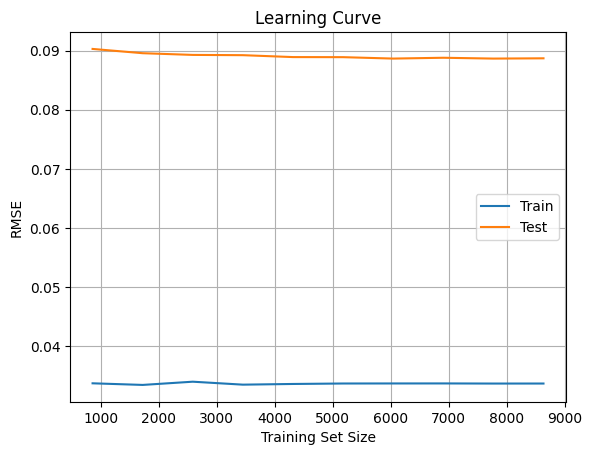

In [164]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

plt.plot(train_sizes, train_rmse, label='Train')
plt.plot(train_sizes, test_rmse, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [209]:
#actually run the model - see effect of # of trees
print("Training model...")
rf = train_number_of_trees(x_train, x_test, y_train, y_test, verbose = 0)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Running RandomForestRegressor on 10 trees
Running RandomForestRegressor on 53 trees


KeyboardInterrupt: 

In [208]:
# run the model - see effect of # of tree splits
print("Training model...")
rf = train_depth(x_train, x_test, y_train, y_test, verbose = 0)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Running RandomForestRegressor with depth 10


KeyboardInterrupt: 

#### Plots + Results

Average distance: 0.11639450372469332


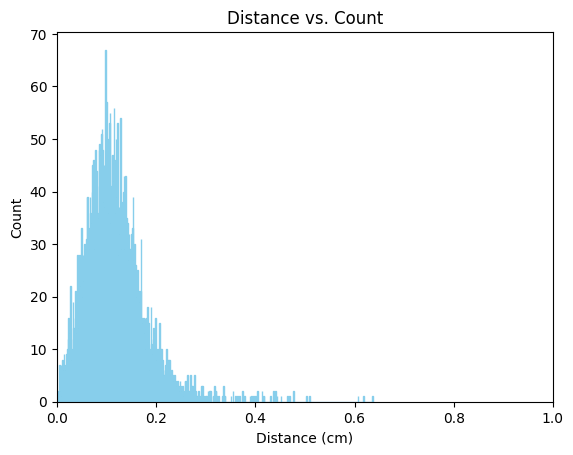

In [226]:
# Plots Distance vs Count

print("Average distance:", np.average(distance))
plt.hist(distance, bins=500, edgecolor='skyblue')
bottom, top = plt.ylim()
# plt.ylim(0, 10)
plt.xlim(0, 1)
plt.xlabel('Distance (cm)')
plt.ylabel('Count')
plt.title('Distance vs. Count')
plt.show()

Average direction: 0.059479844242648794


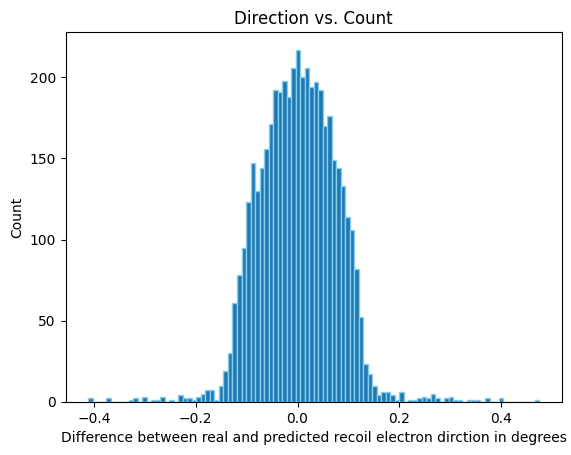

In [227]:
# Plots Direction vs Count

print("Average direction:", np.average(direction))
for i in range(len(direction)):
    direction[i] *= random.choice([1, -1])
    
plt.hist(direction, bins=100, edgecolor='skyblue')
plt.xlabel('Difference between real and predicted recoil electron dirction in degrees')
plt.ylabel('Count')
plt.title('Direction vs. Count')
plt.show()